# Face Covering Detection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the lab materials
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_Folder_PG/Code'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Face_Covering_Detection.ipynb']


# **Preprocessing on Train set and Test set**

In [ ]:
import os
import numpy as np
from PIL import Image

def preprocess_dataset(images_path, labels_path, target_size=(128, 128), convert_gray=True):
    images_list = []  # List to hold preprocessed images
    labels_list = []  # List to hold corresponding labels

    # Process each file in the directory
    for filename in os.listdir(images_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(images_path, filename)
            img = Image.open(img_path).resize(target_size)  # Open and resize image

            # Convert to grayscale if specified
            if convert_gray and img.mode != 'L':
                img = img.convert('L')

            img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]

            # Add channel dimension to grayscale images
            if convert_gray or img.mode == 'L':
                img_array = img_array[..., np.newaxis]

            images_list.append(img_array)  # Add processed image to list

            # Load and append label
            label_filename = os.path.splitext(filename)[0] + '.txt'
            label_path = os.path.join(labels_path, label_filename)
            with open(label_path, 'r') as file:
                label = int(file.read().strip())
            labels_list.append(label)

    return np.array(images_list), np.array(labels_list)  # Return arrays of images and labels

# Paths to your datasets
train_images_path = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/CW_Folder_PG/CW_Dataset/train/images'
train_labels_path = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/CW_Folder_PG/CW_Dataset/train/labels'
x_train, y_train = preprocess_dataset(train_images_path, train_labels_path)

test_images_path = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/CW_Folder_PG/CW_Dataset/test/images'
test_labels_path = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/CW_Folder_PG/CW_Dataset/test/labels'
x_test, y_test = preprocess_dataset(test_images_path, test_labels_path)

print("Preprocessing completed for both training and test datasets.")


Preprocessing completed for both training and test datasets.


First 5 images of Preprocessed Train Set

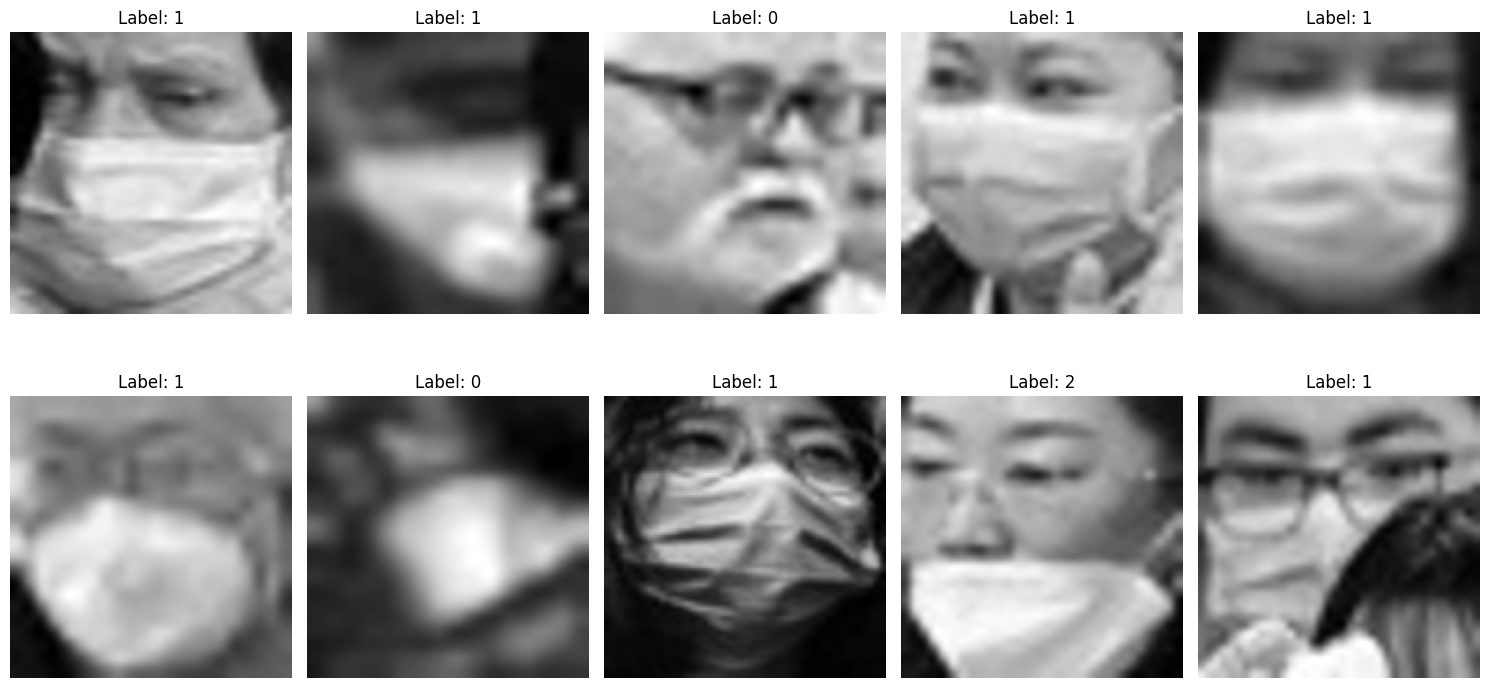

In [ ]:
import matplotlib.pyplot as plt

# Display the first 10 preprocessed images in a 2x5 grid
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

for i in range(10):
    row = i // 5
    col = i % 5
    # If the image is 3D (has a channel dimension), but is still grayscale,
    # we convert it to 2D for displaying.
    image = x_train[i].squeeze()  # This removes the channel dim if it's 1
    axes[row, col].imshow(image, cmap='gray')  # Force grayscale colormap
    axes[row, col].set_title(f"Label: {y_train[i]}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()



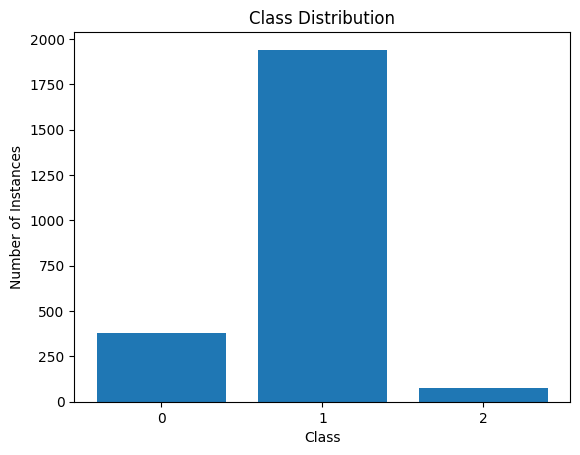

Class 0: Proportion = 0.16
Class 1: Proportion = 0.81
Class 2: Proportion = 0.03


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'y_train' contains class labels
unique_classes, class_counts = np.unique(y_train, return_counts=True)

# Plot class distribution
plt.bar(unique_classes, class_counts)
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Class Distribution')
plt.xticks(unique_classes)
plt.show()

# Calculate class proportions
total_samples = len(y_train)
class_proportions = class_counts / total_samples

# Print class proportions
for cls, prop in zip(unique_classes, class_proportions):
    print(f"Class {cls}: Proportion = {prop:.2f}")



# **1. HOG + SVM**

The below code implements a pipeline for training a Support Vector Machine (SVM) classifier using Histogram of Oriented Gradient (HOG) features for image classification tasks. Initially, it defines functions for extracting HOG features and augmenting data to address class imbalance. The data augmentation includes rotations, shifts, shearing, zooming, and flipping of images. The dataset is split into training and validation sets, and HOG features are extracted and standardized. Hyperparameter tuning is performed using grid search with cross-validation to find the optimal SVM parameters. The trained SVM model is then evaluated on both training and validation sets using metrics like accuracy, confusion matrix, and classification report. Additionally, the confusion matrix for the validation set is visualized using seaborn's heatmap. Finally, the best SVM model along with the scaler is saved to disk for future use.

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.793 total time=   1.6s
[CV 2/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.755 total time=   1.6s
[CV 3/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.767 total time=   1.5s
[CV 4/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.789 total time=   1.1s
[CV 5/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.778 total time=   1.1s
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.796 total time=   2.6s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.790 total time=   2.6s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.810 total time=   2.9s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.790 total time=   3.3s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.802 total time=   2.6s
[CV 1/5] END ..C=0.1, gamma=auto, kernel=linear;, score=0.793 total time=   1.1s
[CV 2/5] END ..C=0.1, gamma=auto, kernel=linear;

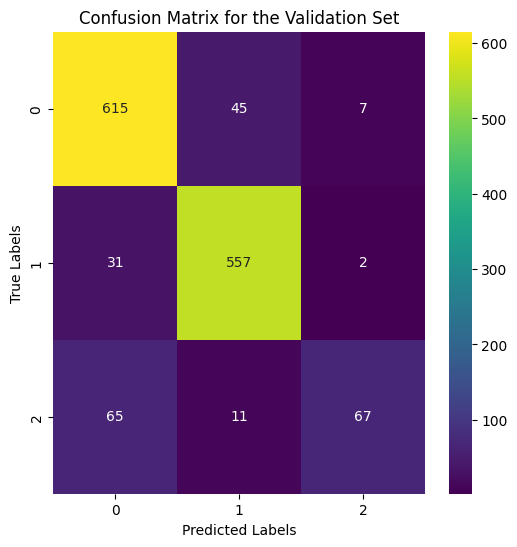

['best_hog_svm_model.pkl']

In [ ]:
# Import necessary libraries
#Reference Lab 5
from skimage.feature import hog  # Import HOG feature extraction
from sklearn import svm  # Import SVM classifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix  # Import evaluation metrics
from sklearn.model_selection import train_test_split, GridSearchCV  # Import data splitting and grid search
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Import image data augmentation
import joblib  # For saving the model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler  # Import feature scaling

# Function to extract HOG features from images
def extract_hog_features(images):
    hog_features = []
    for image in images:
        if image.ndim > 2:
            image = image[:, :, 0]  # Convert to grayscale if not already
        # Extract HOG features from the image
        fd = hog(image, orientations=8, pixels_per_cell=(16, 16),
                 cells_per_block=(1, 1), block_norm='L2', visualize=False)
        hog_features.append(fd)
    return np.array(hog_features)

# Function to augment data for imbalanced classes
def augment_data(x_data, y_data, classes_to_augment=[0, 2], augment_factor=5):
    # Setup the data augmentation configuration
    data_gen = ImageDataGenerator(
        rotation_range=10,          # Rotate the image within a range of 10 degrees
        width_shift_range=0.1,      # Horizontally shift the image by 10%
        height_shift_range=0.1,     # Vertically shift the image by 10%
        shear_range=0.1,            # Shear the image by 10%
        zoom_range=0.1,             # Zoom in/out by 10%
        horizontal_flip=True,       # Allow horizontal flipping of the image
        fill_mode='nearest'         # Fill in new pixels with the nearest filled value
    )
    x_augmented = []  # List to store augmented images
    y_augmented = []  # List to store labels of augmented images
    for class_label in classes_to_augment:
        # Filter out images of the specified classes
        x_class = x_data[y_data == class_label]
        # Augment images
        for _ in range(augment_factor):
            augmented_images = data_gen.flow(x_class, batch_size=len(x_class), shuffle=False)
            for aug_img in augmented_images:
                x_augmented.extend(aug_img)
                y_augmented.extend([class_label] * len(aug_img))
                break  # we only need one set per batch
    # Combine original and augmented data
    x_new = np.concatenate((x_data, np.array(x_augmented)))
    y_new = np.concatenate((y_data, np.array(y_augmented)))
    return x_new, y_new

# Assuming x_train and y_train are loaded and preprocessed

# Augment data for specified classes and split into training and validation sets
x_train, y_train = augment_data(x_train, y_train, classes_to_augment=[0, 2], augment_factor=5)
x_train_hog = extract_hog_features(x_train)  # Extract HOG features for training data
x_test_hog = extract_hog_features(x_test)    # Extract HOG features for test data

# Split data into training and validation sets
x_train_hog, x_val_hog, y_train, y_val = train_test_split(x_train_hog, y_train, test_size=0.3, random_state=42)

# Initialize and configure the scaler
scaler = StandardScaler()
x_train_hog_scaled = scaler.fit_transform(x_train_hog)  # Fit and transform the training data
x_val_hog_scaled = scaler.transform(x_val_hog)          # Transform the validation data based on the fitted scaler

# Save the scaler for later use
joblib.dump(scaler, 'hog_scaler.pkl')

# Define the parameter grid for grid search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf']
}

# Initialize and configure the SVM classifier
svm_clf = svm.SVC(class_weight='balanced')  # Initialize SVM with balanced class weights
grid_search = GridSearchCV(svm_clf, param_grid, refit=True, verbose=3, cv=5)  # Perform grid search
grid_search.fit(x_train_hog_scaled, y_train)  # Note the use of scaled HOG features here

print("Best parameters found:", grid_search.best_params_)  # Print the best parameters found
best_clf = grid_search.best_estimator_  # Get the best SVM classifier

# Predict and evaluate as before using scaled HOG features
y_train_pred = best_clf.predict(x_train_hog_scaled)
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))

y_pred_val = best_clf.predict(x_val_hog_scaled)
val_accuracy = accuracy_score(y_val, y_pred_val)
print("Validation Accuracy:", val_accuracy)

conf_matrix = confusion_matrix(y_val, y_pred_val)
print("Confusion Matrix:\n", conf_matrix)

class_report = classification_report(y_val, y_pred_val)
print("Classification Report:\n", class_report)

# Visualize the confusion matrix using seaborn's heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.title('Confusion Matrix for the Validation Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Save the model
joblib.dump(best_clf, 'best_hog_svm_model.pkl')

# Apply the best HOG+SVM model on the testset

The below code evaluates the performance of a pre-trained Support Vector Machine (SVM) model on a test dataset using Histogram of Oriented Gradients (HOG) features. It begins by loading the SVM model and scaler previously saved during training. The test dataset's HOG features are then transformed using the scaler to ensure consistency in preprocessing. Next, the model predicts labels for the test set based on these scaled features. Subsequently, the code calculates key evaluation metrics, including test accuracy, confusion matrix, and classification report, providing insights into the model's classification performance. Finally, the confusion matrix is visualized using seaborn's heatmap function, facilitating a graphical interpretation of the model's classification performance across different classes.

Test Accuracy: 0.8580786026200873
Confusion Matrix:
 [[ 25  26   0]
 [ 23 364   1]
 [  2  13   4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.49      0.50        51
           1       0.90      0.94      0.92       388
           2       0.80      0.21      0.33        19

    accuracy                           0.86       458
   macro avg       0.73      0.55      0.58       458
weighted avg       0.85      0.86      0.85       458



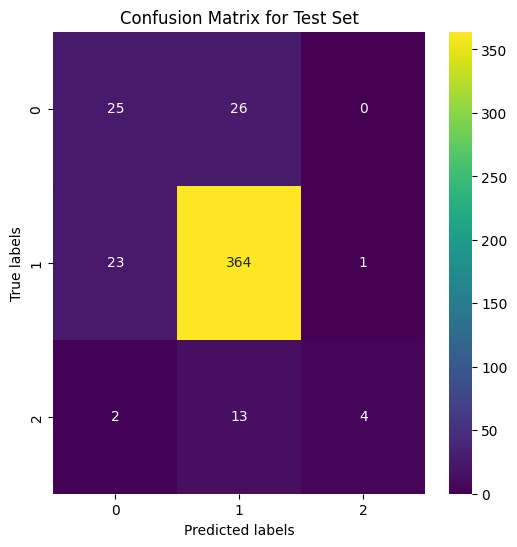

In [ ]:
from sklearn.preprocessing import StandardScaler  # Import StandardScaler for feature scaling
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  # Import evaluation metrics
import joblib  # Import joblib for loading the model and scaler

# Load the trained model and scaler
model = joblib.load('best_hog_svm_model.pkl')  # Load the trained SVM model
scaler = joblib.load('hog_scaler.pkl')         # Load the scaler used for feature scaling during training

# Transform the test HOG features using the loaded scaler
x_test_scaled = scaler.transform(x_test_hog)  # Scale the test features

# Predict on the test set using the trained model
y_test_pred = model.predict(x_test_scaled)  # Predict the labels for the test set

# Calculate and print the test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)  # Compute the accuracy of the predictions
print("Test Accuracy:", test_accuracy)  # Print the test accuracy

# Generate and display the confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_test_pred)  # Compute the confusion matrix
print("Confusion Matrix:\n", conf_matrix)  # Print the confusion matrix

class_report = classification_report(y_test, y_test_pred)  # Generate the classification report
print("Classification Report:\n", class_report)  # Print the classification report

# Visualize the confusion matrix using seaborn's heatmap
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='viridis', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Test Set')
plt.show()  # Display the heatmap of the confusion matrix


# **2. SIFT + SVM**

The below code implements a pipeline for image classification using the bag-of-visual-words (BoVW) approach with Scale-Invariant Feature Transform (SIFT) descriptors and SVM classification. It begins by importing necessary libraries and defining a function to augment data for imbalanced classes. Data augmentation is applied to the training set, and then the dataset is split into training and validation sets. SIFT features are extracted from the training images, and their keypoints are visualized using matplotlib. The descriptors are clustered using MiniBatchKMeans to create a visual vocabulary. Histograms of visual words are created for each training image, which are then standardized. Grid search is used to find the best parameters for the SVM model. The model is trained and evaluated on the validation set, and the performance metrics including accuracy, confusion matrix, and classification report are printed and visualized. Finally, the trained models (SVM and KMeans) along with the scaler are saved to disk for future use.

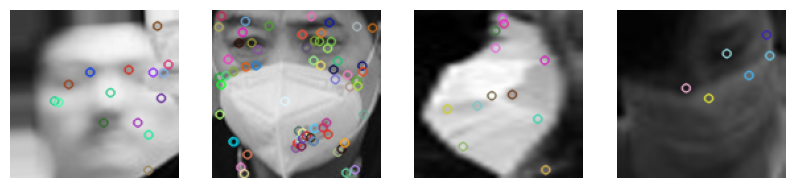

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.544 total time=   1.3s
[CV 2/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.618 total time=   1.2s
[CV 3/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.609 total time=   1.0s
[CV 4/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.619 total time=   0.8s
[CV 5/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.555 total time=   0.8s
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.610 total time=   0.9s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.606 total time=   0.9s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.612 total time=   0.9s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.585 total time=   0.9s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.623 total time=   0.9s
[CV 1/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.265 total time=   0.8s
[CV 2/5] END ...C=0.1, gamma=scale, kernel=poly

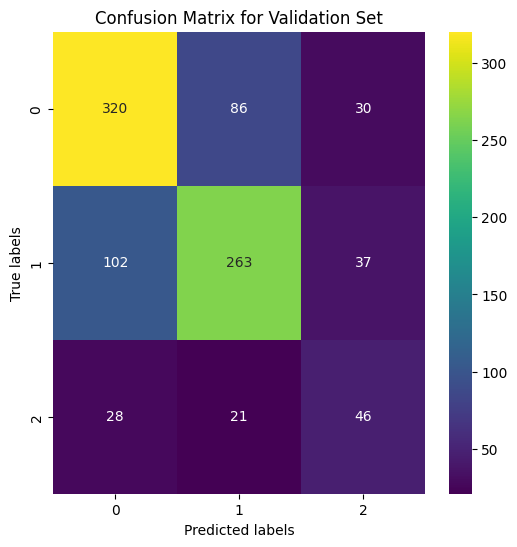

SIFT_svm model saved successfully!
KMeans model saved successfully!
Scaler saved successfully!


In [ ]:
# Import necessary libraries
import cv2
import numpy as np
from skimage import img_as_ubyte
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Function to augment data for imbalanced classes
def augment_data(x_data, y_data, classes_to_augment=[0, 2], augment_factor=5):
    # Setup the data augmentation configuration
    data_gen = ImageDataGenerator(
        rotation_range=10,  # Rotate the image within a range of 10 degrees
        width_shift_range=0.1,  # Horizontally shift the image by 10%
        height_shift_range=0.1,  # Vertically shift the image by 10%
        shear_range=0.1,  # Shear the image by 10%
        zoom_range=0.1,  # Zoom in/out by 10%
        horizontal_flip=True,  # Allow horizontal flipping of the image
        fill_mode='nearest'  # Fill in new pixels with the nearest filled value
    )
    x_augmented = []  # List to store augmented images
    y_augmented = []  # List to store labels of augmented images
    for class_label in classes_to_augment:
        # Filter out images of the specified classes
        x_class = x_data[y_data == class_label]
        x_class = x_class.reshape((x_class.shape[0],) + x_class.shape[1:])
        # Generate augmented images
        aug_iter = data_gen.flow(x_class, batch_size=1)
        for _ in range(x_class.shape[0] * augment_factor):
            x_augmented.append(next(aug_iter)[0])
            y_augmented.append(class_label)
    # Combine original and augmented data
    x_new = np.concatenate((x_data, np.array(x_augmented)))
    y_new = np.concatenate((y_data, np.array(y_augmented)))
    return x_new, y_new

# Augment data for specified classes and split into training and validation sets
x_train, y_train = augment_data(x_train, y_train, classes_to_augment=[0, 2], augment_factor=5)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Initialize the SIFT feature detector
sift = cv2.SIFT_create()
des_list = []  # List to store descriptors
y_train_list = []  # List to store labels corresponding to the descriptors

# Setup figure to visualize keypoints detected by SIFT
fig, ax = plt.subplots(1, 4, figsize=(10, 8), sharey=True)
for i in range(len(x_train)):
    img = img_as_ubyte(x_train[i])  # Convert the image for SIFT processing
    kp, des = sift.detectAndCompute(img, None)  # Detect keypoints and compute descriptors
    if i < 4:  # Display keypoints on the first 4 images
        img_with_SIFT = cv2.drawKeypoints(img, kp, img)
        ax[i].imshow(img_with_SIFT, cmap='gray')
        ax[i].set_axis_off()
    if des is not None:
        des_list.append(des)  # Store descriptors
        y_train_list.append(y_train[i])  # Store corresponding labels
plt.show()

# Cluster the descriptors using MiniBatchKMeans to create a visual vocabulary
des_array = np.vstack(des_list) if des_list else np.empty((0, 128))
k = 10 * len(np.unique(y_train))  # Determine the number of clusters
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=max(des_array.shape[0] // 4, 1), n_init=4)
kmeans.fit(des_array)

# Create histograms of visual words for each training image
x_train_hist = [np.bincount(kmeans.predict(des), minlength=k) / len(des) if des is not None else np.zeros(k) for des in des_list]

# Standardize features before training the SVM
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_hist)

# Configure and run grid search to find the best SVM parameters
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'rbf', 'poly']}
grid_search = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=5, verbose=3)
grid_search.fit(x_train_scaled, y_train_list)

# Compute and print the training accuracy
y_train_pred = grid_search.best_estimator_.predict(x_train_scaled)
print("Training Accuracy:", accuracy_score(y_train_list, y_train_pred))

# Prepare and predict on the validation set
x_val_hist = []
for img in x_val:
    img = img_as_ubyte(img)  # Convert the image for SIFT processing
    _, val_des = sift.detectAndCompute(img, None)  # Compute descriptors for validation images
    val_hist = np.bincount(kmeans.predict(val_des), minlength=k) / len(val_des) if val_des is not None else np.zeros(k)
    x_val_hist.append(val_hist)
x_val_scaled = scaler.transform(x_val_hist)  # Scale the histograms

# Predict and evaluate the validation set
y_val_pred = grid_search.best_estimator_.predict(x_val_scaled)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Confusion Matrix (Validation):\n", confusion_matrix(y_val, y_val_pred))
print("Classification Report (Validation):\n", classification_report(y_val, y_val_pred))

# Plot the confusion matrix for the validation set
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt='g', cmap='viridis', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Validation Set')
plt.show()

# Save the trained models and scaler to disk for later use
joblib.dump(grid_search.best_estimator_, 'best_model_sift_svm.pkl')  # Save the best SVM model
print("SIFT_svm model saved successfully!")
joblib.dump(kmeans, 'kmeans_sift_svm.pkl')  # Save the k-means model
print("KMeans model saved successfully!")
joblib.dump(scaler, 'scaler_sift_svm.pkl')  # Save the scaler
print("Scaler saved successfully!")


## Apply SIFT+SVM the model on Tests set

The below code segment performs inference and evaluation using a pre-trained Support Vector Machine (SVM) model on a set of test images. It begins by loading the SVM model from a saved file and initializing a Scale-Invariant Feature Transform (SIFT) detector. Subsequently, it extracts SIFT descriptors from the test images and clusters them using K-means clustering to create histograms of visual words. These histograms are scaled using the same scaler that was used during training. The scaled features are then fed into the SVM model to predict labels for the test images. Following prediction, the code evaluates the model's performance by computing accuracy, generating a confusion matrix, and producing a classification report. Finally, it visualizes the model's performance using a heatmap representation of the confusion matrix. Overall, this code segment facilitates the assessment of the SVM model's effectiveness in classifying objects within the test images and provides insights into its performance metrics through evaluation and visualization.

Test Accuracy: 0.6768558951965066
Confusion Matrix (Test):
 [[ 29  18   4]
 [ 84 278  26]
 [  6  10   3]]
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.24      0.57      0.34        51
           1       0.91      0.72      0.80       388
           2       0.09      0.16      0.12        19

    accuracy                           0.68       458
   macro avg       0.41      0.48      0.42       458
weighted avg       0.80      0.68      0.72       458



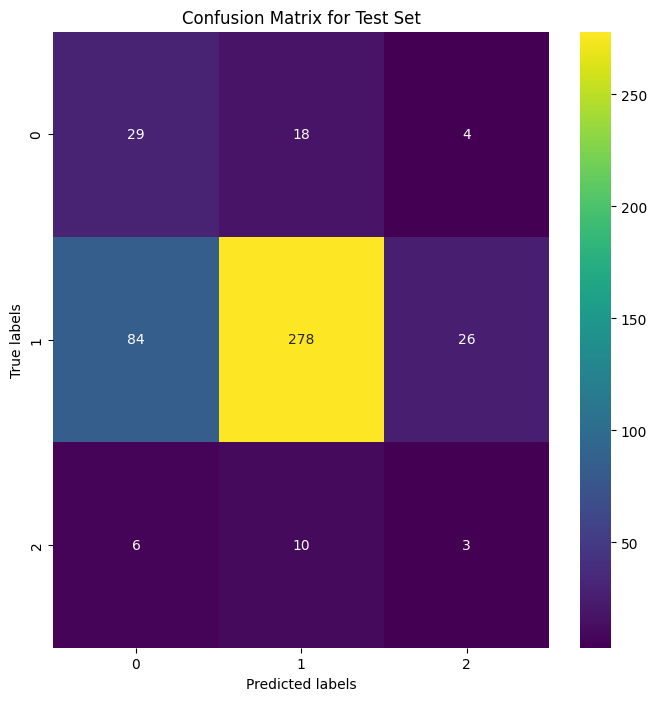

In [ ]:
# Import necessary libraries
import cv2
import numpy as np
from skimage import img_as_ubyte  # Convert images to uint8 format
import matplotlib.pyplot as plt
import seaborn as sns  # For plotting the confusion matrix
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  # For model evaluation
import joblib  # For loading the trained model

# Load the trained SVM model
model = joblib.load('best_model_sift_svm.pkl')  # Ensure this matches the file name used when saving the model

# Initialize SIFT detector
sift = cv2.SIFT_create()
des_list_test = []  # List to store descriptors of test images

# Extract SIFT descriptors for each test image
for img in x_test:
    img_uint8 = img_as_ubyte(img)  # Convert images to uint8 format
    kp, des = sift.detectAndCompute(img_uint8, None)  # Detect keypoints and compute descriptors
    if des is not None:
        des_list_test.append(des.astype(np.float32))  # Convert descriptors to float32 to match the training data type
    else:
        des_list_test.append(np.zeros((1, 128), dtype=np.float32))  # Handle images with no keypoints/descriptors

# Create histograms of visual words for each test image
x_test_hist = np.array([np.bincount(kmeans.predict(des), minlength=kmeans.n_clusters) / len(des) if des.size > 0 else np.zeros(kmeans.n_clusters) for des in des_list_test])

# Scale features using the same scaler as training data
x_test_scaled = scaler.transform(x_test_hist)

# Predict labels for test data
y_test_pred = model.predict(x_test_scaled)

# Model evaluation on the test set
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Confusion Matrix (Test):\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report (Test):\n", classification_report(y_test, y_test_pred))

# Plot the confusion matrix for visualization
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='g', cmap='viridis', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Test Set')
plt.show()



# **3. CNN** - Mobilenet

This below code performs the training of (CNN) using transfer learning with the MobileNetV2 architecture. It begins by loading and preprocessing images along with their corresponding labels, splitting the dataset into training and validation sets. Subsequently, data augmentation techniques are applied to enhance the robustness of the model. The MobileNetV2 architecture is then utilized as the base model, onto which custom layers are added. After compiling the model with appropriate optimizer and loss function, training commences, facilitated by the ModelCheckpoint callback to preserve the best-performing model. Following training, the model's weights are loaded to evaluate its performance on both the training and validation sets, generating accuracy scores, confusion matrices, and classification reports. Visualizations, including a confusion matrix for the validation set and loss/accuracy curves.

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
60/59 [==============================] - ETA: 0s - loss: 0.4305 - accuracy: 0.8480
Epoch 1: val_accuracy improved from -inf to 0.89979, saving model to best_CNNmodel.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


59/59 [==============================] - 43s 621ms/step - loss: 0.4305 - accuracy: 0.8480 - val_loss: 0.2938 - val_accuracy: 0.8998
Epoch 2/10
60/59 [==============================] - ETA: 0s - loss: 0.2581 - accuracy: 0.9128
Epoch 2: val_accuracy improved from 0.89979 to 0.90814, saving model to best_CNNmodel.h5
59/59 [==============================] - 36s 599ms/step - loss: 0.2581 - accuracy: 0.9128 - val_loss: 0.2537 - val_accuracy: 0.9081
Epoch 3/10
60/59 [==============================] - ETA: 0s - loss: 0.2329 - accuracy: 0.9149
Epoch 3: val_accuracy improved from 0.90814 to 0.91858, saving model to best_CNNmodel.h5
59/59 [==============================] - 35s 579ms/step - loss: 0.2329 - accuracy: 0.9149 - val_loss: 0.2260 - val_accuracy: 0.9186
Epoch 4/10
60/59 [==============================] - ETA: 0s - loss: 0.2059 - accuracy: 0.9290
Epoch 4: val_accuracy improved from 0.91858 to 0.92067, saving model to best_CNNmodel.h5
59/59 [==============================] - 36s 594ms/step

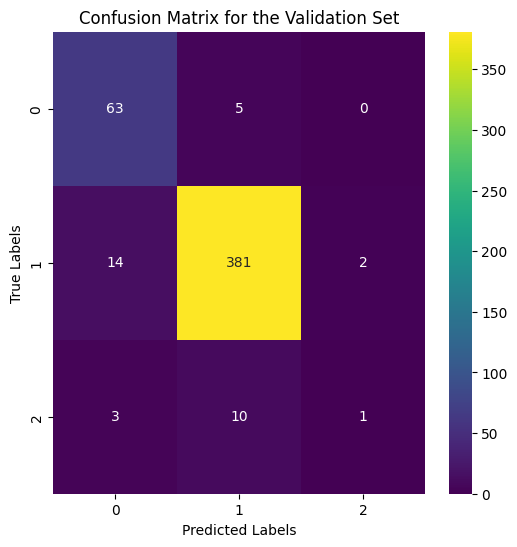

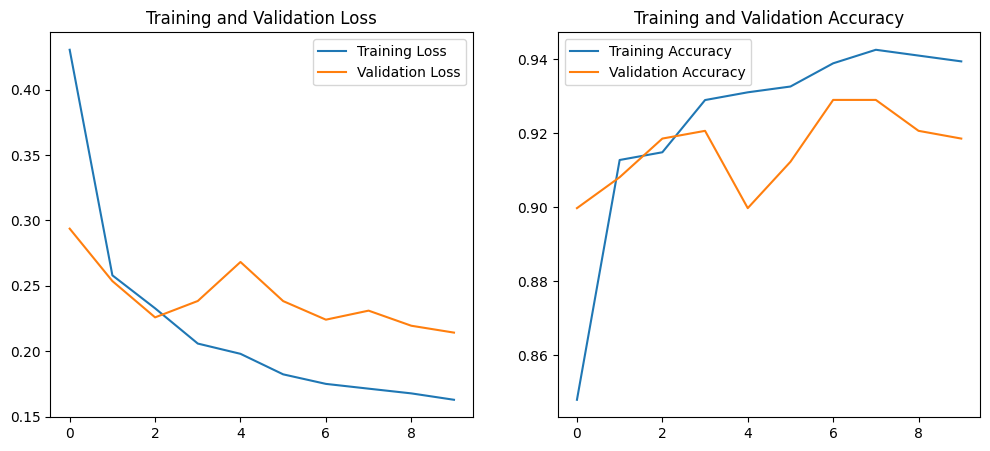

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[0][0]']        

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.callbacks import ModelCheckpoint

# Directories for images and labels
images_dir = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/CW_Folder_PG/CW_Dataset/train/images'
labels_dir = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/CW_Folder_PG/CW_Dataset/train/labels'

# Arrays to store images and labels
images = []
labels = []

# Load and preprocess images and labels
for filename in os.listdir(images_dir):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        # Load and preprocess each image
        img_path = os.path.join(images_dir, filename)
        img = Image.open(img_path).convert('RGB')
        img = img.resize((128, 128))
        img_array = np.array(img) / 127.5 - 1
        images.append(img_array)

        # Load corresponding label
        label_filename = os.path.splitext(filename)[0] + '.txt'
        label_path = os.path.join(labels_dir, label_filename)
        with open(label_path, 'r') as file:
            label = int(file.read().strip())
        labels.append(label)

# Convert list of images and labels to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Split dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Data augmentation configuration
data_augmentation = ImageDataGenerator(
    rotation_range=15,          # Degree range for random rotations
    width_shift_range=0.2,      # Fraction of total width to shift images horizontally
    height_shift_range=0.2,     # Fraction of total height to shift images vertically
    shear_range=0.2,            # Shear intensity (shear angle in radians)
    zoom_range=0.2,             # Range for random zoom
    horizontal_flip=True,       # Randomly flip inputs horizontally
    fill_mode='nearest'         # Points outside the boundaries of the input are filled
)

# MobileNetV2 as the base model for transfer learning
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet', pooling='avg')
base_model.trainable = False

# Adding custom layers on top of the base model
x = base_model.output
predictions = Dense(len(np.unique(labels)), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model checkpoint to save the best model
checkpoint = ModelCheckpoint(
    'best_CNNmodel.h5',  # Path where the model is saved
    monitor='val_accuracy',  # Metric name to monitor
    save_best_only=True,  # Save only the best model
    verbose=1  # Verbosity level
)

# Use data augmentation generator to train the model
train_datagen = data_augmentation.flow(x_train, y_train, batch_size=32)

# Train the model using the checkpoint
history = model.fit(
    train_datagen,
    steps_per_epoch=len(x_train) / 32,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint]
)

# Load the best model
model.load_weights('best_CNNmodel.h5')

# Evaluation on training data
y_train_pred = np.argmax(model.predict(x_train), axis=1)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

# Evaluation on validation data
y_val_pred = np.argmax(model.predict(x_val), axis=1)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

# Print confusion matrix and classification report
conf_matrix = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:\n", conf_matrix)
class_report = classification_report(y_val, y_val_pred)
print("Classification Report:\n", class_report)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for the Validation Set')
plt.show()

# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

# Display the model's architecture
model.summary()


# Apply the best CNN model on testset


This below code loads the saved best pre-trained(CNN) model and evaluates its performance on a test set of images and labels. It loads the test images and corresponding labels from specified directories, preprocesses the images, and feeds them into the CNN model to make predictions. The accuracy of the model on the test set is calculated, and a confusion matrix and classification report are generated to assess its performance further. Finally, the results are visualized using a heatmap for the confusion matrix, and the classification report is printed.

15/15 [==============================] - 6s 278ms/step
Test Accuracy: 0.9388646288209607


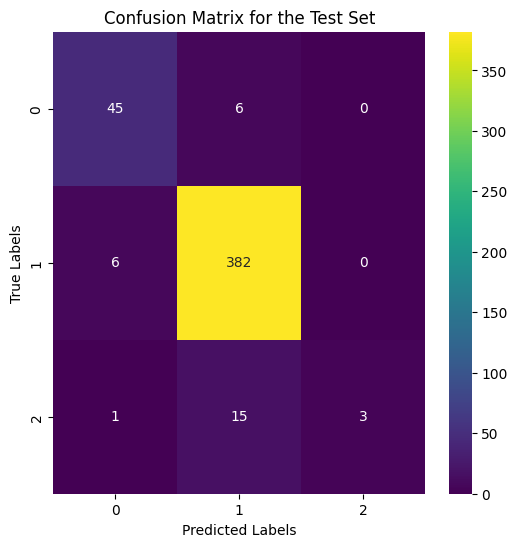

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.88      0.87        51
           1       0.95      0.98      0.97       388
           2       1.00      0.16      0.27        19

    accuracy                           0.94       458
   macro avg       0.94      0.67      0.70       458
weighted avg       0.94      0.94      0.93       458



In [ ]:
import numpy as np  # Import NumPy library for numerical computations
import matplotlib.pyplot as plt  # Import matplotlib library for data visualization
import os  # Import os module for interacting with the operating system
from PIL import Image  # Import Image module from PIL library for image processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Import ImageDataGenerator for data augmentation
from tensorflow.keras.models import load_model  # Import load_model to load pre-trained models
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  # Import metrics for model evaluation
import seaborn as sns  # Import seaborn for enhanced data visualization

# Path to test images and labels
test_images_dir = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/CW_Folder_PG/CW_Dataset/test/images'
test_labels_dir = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/CW_Folder_PG/CW_Dataset/test/labels'

# Load and preprocess test images and labels
test_images = []  # Initialize an empty list to store test images
test_labels = []  # Initialize an empty list to store corresponding test labels

# Loop through test image directory
for filename in os.listdir(test_images_dir):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        # Load and preprocess each image
        img_path = os.path.join(test_images_dir, filename)  # Construct full image path
        img = Image.open(img_path).convert('RGB')  # Open and convert image to RGB format
        img = img.resize((128, 128))  # Resize image to (128, 128)
        img_array = np.array(img) / 127.5 - 1  # Convert image to array and normalize
        test_images.append(img_array)  # Append preprocessed image to list

        # Load corresponding label
        label_filename = os.path.splitext(filename)[0] + '.txt'  # Generate label file name
        label_path = os.path.join(test_labels_dir, label_filename)  # Construct full label path
        with open(label_path, 'r') as file:
            label = int(file.read().strip())  # Read label from file
        test_labels.append(label)  # Append label to list

# Convert lists to numpy arrays
test_images = np.array(test_images)  # Convert list of images to numpy array
test_labels = np.array(test_labels)  # Convert list of labels to numpy array

# Load the best model
model = load_model('best_CNNmodel.h5')  # Load pre-trained CNN model

# Make predictions on the test set
test_predictions = model.predict(test_images)  # Make predictions on test images
test_pred_classes = np.argmax(test_predictions, axis=1)  # Get predicted classes

# Evaluate the model on the test set
test_accuracy = accuracy_score(test_labels, test_pred_classes)  # Calculate test accuracy
print("Test Accuracy:", test_accuracy)  # Print test accuracy

# Generate the confusion matrix and classification report
test_conf_matrix = confusion_matrix(test_labels, test_pred_classes)  # Generate confusion matrix
test_class_report = classification_report(test_labels, test_pred_classes)  # Generate classification report

# Display the confusion matrix
plt.figure(figsize=(6, 6))  # Set figure size
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.xlabel('Predicted Labels')  # Set x-axis label
plt.ylabel('True Labels')  # Set y-axis label
plt.title('Confusion Matrix for the Test Set')  # Set title
plt.show()  # Show plot

# Print the classification report
print("Classification Report:\n", test_class_report)  # Print classification report



# ROC Curve for each class

The below code calculates and plots Receiver Operating Characteristic (ROC) curves for each class in a multi-class classification problem. It first binarizes the labels for multi-class ROC analysis, then computes the ROC curve and Area Under the Curve (AUC) for each class. Finally, it plots all ROC curves on a single plot with a black background, each curve labeled with the corresponding class and its AUC value. And, it sets various plot properties such as axis labels, title, legend, and grid color to enhance readability.

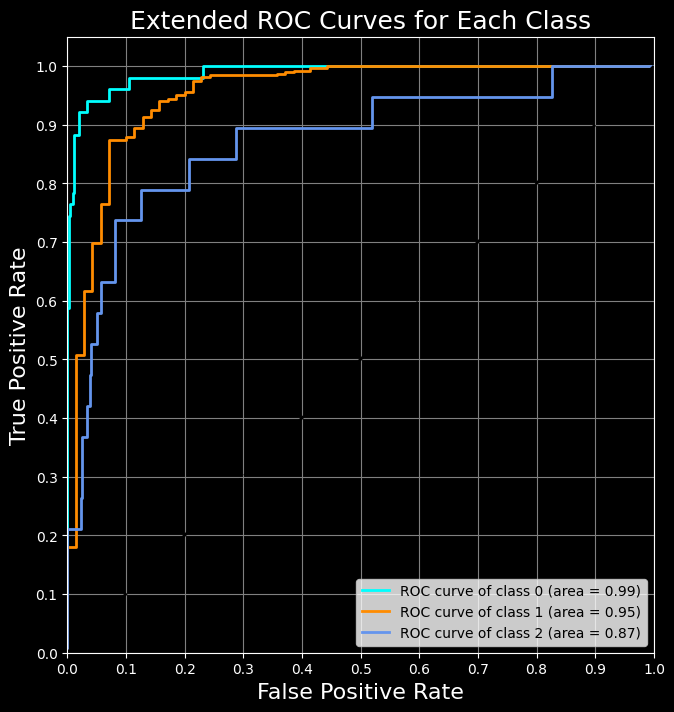

In [ ]:
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize the labels for multi-class ROC analysis
y_bin = label_binarize(test_labels, classes=np.unique(test_labels))
n_classes = y_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], test_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8), facecolor='black')  # Set the background to black
ax = plt.gca()
ax.set_facecolor('black')  # Set the plot background to black
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'lime', 'magenta', 'gold', 'teal', 'white'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16, color='white')
plt.ylabel('True Positive Rate', fontsize=16, color='white')
plt.title('Extended ROC Curves for Each Class', fontsize=18, color='white')
plt.legend(loc="lower right")
plt.grid(True, color='gray')
plt.xticks(np.arange(0.0, 1.1, step=0.1), color='white')
plt.yticks(np.arange(0.0, 1.1, step=0.1), color='white')
plt.tick_params(axis='both', colors='white')
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

